In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from imutils import paths
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [3]:
data = []
labels = []
imagePaths = list(paths.list_images('./dataset/'))

In [4]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    data.append(image)
    if 'with_mask' in label:
        labels.append('with_mask')
    else:
        labels.append('without_mask')

C:\Users\dell\Anaconda3\envs\nlp_course\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [8]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [9]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

C:\Users\dell\Anaconda3\envs\nlp_course\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [10]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
for layer in baseModel.layers:
    layer.trainable = False

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [15]:
checkpoint = ModelCheckpoint('model1.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=9,
                          verbose=1,
                          restore_best_weights=True
                          )
callbacks=[checkpoint, earlystop]

In [19]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

AttributeError: module 'tensorflow_core._api.v2.config' has no attribute 'list_physical_devices'

In [20]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1)

Train for 95 steps, validate on 767 samples
Epoch 1/20
94/95 [============================>.] - ETA: 8s - loss: 0.5008 - accuracy: 0.7592 
Epoch 00001: val_loss improved from inf to 0.42845, saving model to model1.h5
95/95 [==============================] - 802s 8s/step - loss: 0.4987 - accuracy: 0.7597 - val_loss: 0.4284 - val_accuracy: 0.8043
Epoch 2/20
94/95 [============================>.] - ETA: 6s - loss: 0.2937 - accuracy: 0.8814 
Epoch 00002: val_loss improved from 0.42845 to 0.35269, saving model to model1.h5
95/95 [==============================] - 675s 7s/step - loss: 0.2933 - accuracy: 0.8817 - val_loss: 0.3527 - val_accuracy: 0.8451
Epoch 3/20
94/95 [============================>.] - ETA: 6s - loss: 0.2256 - accuracy: 0.9177 
Epoch 00003: val_loss improved from 0.35269 to 0.28765, saving model to model1.h5
95/95 [==============================] - 665s 7s/step - loss: 0.2257 - accuracy: 0.9166 - val_loss: 0.2877 - val_accuracy: 0.8709
Epoch 4/20
94/95 [=====================

In [23]:
preds = model.predict(testX, verbose=1)

767/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [25]:
preds = np.argmax(preds, axis=1)

In [26]:
print(classification_report(testY.argmax(axis=1), preds,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.96      0.85      0.90       383
without_mask       0.87      0.97      0.91       384

    accuracy                           0.91       767
   macro avg       0.91      0.91      0.91       767
weighted avg       0.91      0.91      0.91       767



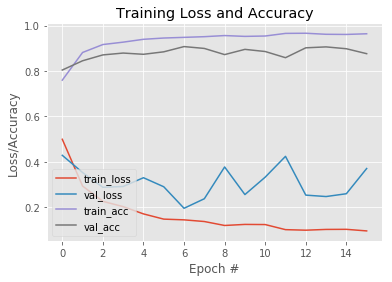

In [30]:
N = EPOCHS-4
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [31]:
from sklearn import metrics
metrics.accuracy_score(testY.argmax(axis=1), preds)

0.9087353324641461

In [32]:
lb.classes_

array(['with_mask', 'without_mask'], dtype='<U12')

In [35]:
import cv2
img = cv2.imread('./dataset/with_mask/0_0_0 copy 10.jpg')
image = load_img('./dataset/with_mask/0_0_0 copy 10.jpg', target_size=(224, 224))
image = img_to_array(image)
image = preprocess_input(image)
image=np.expand_dims(image, axis=0)
model.predict(image)

array([[0.95761544, 0.04238459]], dtype=float32)